In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import gc

In [2]:
CONFIG = {
    'input_steps': 24,
    'output_steps': 24,
    'stride': 1,
    'features': [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m",
        "apparent_temperature", "weather_code", "pressure_msl",
        "surface_pressure", "cloud_cover", "cloud_cover_low",
        "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m",
        "wind_speed_100m", "wind_direction_10m", "wind_direction_100m",
        "wind_gusts_10m"
    ],
    'target': 'rain',
    'batch_size': 32,
    'epochs': 20
}


In [3]:
class DataPreprocessor:
    def __init__(self, config):
        self.config = config
        self.scalers = {}
        self.label_encoder = LabelEncoder()

    def transform_rainfall(self, data):
        """Log transform rainfall data"""
        return np.log1p(data)

    def inverse_transform_rainfall(self, data):
        """Inverse transform log-transformed rainfall data"""
        return np.expm1(data)

    def load_and_prepare_data(self, filepath):
        """Load data from CSV and prepare initial dataframe"""
        print("Loading data...")
        df = pd.read_csv(filepath)
        df['time'] = pd.to_datetime(df['time'])
        df['location_encoded'] = self.label_encoder.fit_transform(df['location'])
        print("Label and number: ", list(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_)))))
        return df

    def scale_features(self, location_data, location, is_training=True):
        """Scale features for a specific location"""
        if is_training:
            self.scalers[location] = {
                feature: MinMaxScaler() for feature in self.config['features']
            }
            # Fit and transform
            for feature in self.config['features']:
                location_data[feature] = self.scalers[location][feature].fit_transform(
                    location_data[feature].values.reshape(-1, 1)
                )
        else:
            # Transform only
            for feature in self.config['features']:
                location_data[feature] = self.scalers[location][feature].transform(
                    location_data[feature].values.reshape(-1, 1)
                )

        return location_data

    def create_sequences(self, data, location_encoded):
        """Create sequences for a single location"""
        input_steps = self.config['input_steps']
        output_steps = self.config['output_steps']
        feature_count = len(self.config['features'])

        X, y = [], []

        for i in range(0, len(data) - input_steps - output_steps + 1, self.config['stride']):
            # Input sequence
            input_seq = np.column_stack([
                data[i:i + input_steps, :feature_count],
                np.full(input_steps, location_encoded)
            ])

            # Target sequence
            target_seq = data[
                i + input_steps:i + input_steps + output_steps,
                -1
            ]

            X.append(input_seq)
            y.append(target_seq)

            # Free memory periodically
            if len(X) % 1000 == 0:
                gc.collect()

        return np.array(X), np.array(y)

    def process_location(self, df, location, is_training=True):
        """Process data for a single location"""
        print(f"Processing location: {location}")

        # Get data for this location
        location_data = df[df['location'] == location].copy()
        location_data = location_data.sort_values('time')

        # Scale features
        location_data = self.scale_features(location_data, location, is_training)

        # Transform rainfall
        location_data['rain_transformed'] = self.transform_rainfall(
            location_data[self.config['target']].values
        )

        # Prepare data array
        data_array = location_data[
            self.config['features'] + ['rain_transformed']
        ].values

        # Create sequences
        X, y = self.create_sequences(
            data_array,
            location_data['location_encoded'].iloc[0]
        )

        return X, y, location_data.index

    def split_data(self, X, y, train_ratio=0.8):
        """Split data into training and testing sets"""
        split_idx = int(len(X) * train_ratio)

        X_train = X[:split_idx]
        X_test = X[split_idx:]
        y_train = y[:split_idx]
        y_test = y[split_idx:]

        return X_train, X_test, y_train, y_test

    def process_all_locations(self, df, train_ratio=0.8):
        """Process all locations and combine data"""
        X_train_all = []
        X_test_all = []
        y_train_all = []
        y_test_all = []

        locations = df['location'].unique()

        for location in locations:
            # Process location data
            X, y, _ = self.process_location(df, location)

            # Split data
            X_train, X_test, y_train, y_test = self.split_data(X, y, train_ratio)

            # Append to lists
            X_train_all.append(X_train)
            X_test_all.append(X_test)
            y_train_all.append(y_train)
            y_test_all.append(y_test)

            # Clear memory
            gc.collect()

        # Combine all data
        X_train = np.vstack(X_train_all)
        X_test = np.vstack(X_test_all)
        y_train = np.vstack(y_train_all)
        y_test = np.vstack(y_test_all)

        return X_train, X_test, y_train, y_test

In [4]:
class RainfallPredictor:
    def __init__(self, config, preprocessor):
        self.config = config
        self.preprocessor = preprocessor
        self.model = None

    def build_model(self):
        """Create LSTM model architecture"""
        input_shape = (self.config['input_steps'], len(self.config['features']) + 1)

        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=input_shape),
            BatchNormalization(),
            Dropout(0.2),

            LSTM(64, return_sequences=False),
            BatchNormalization(),
            Dropout(0.2),

            Dense(64, activation='relu'),
            BatchNormalization(),

            Dense(32, activation='relu'),
            BatchNormalization(),

            Dense(self.config['output_steps'], activation='relu')
        ])

        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val=None, y_val=None, **kwargs):
        """Train the model with callbacks"""
        if X_val is None:
            # Use validation split if validation data not provided
            validation_split = kwargs.get('validation_split', 0.1)
            validation_data = None
        else:
            validation_split = 0.0
            validation_data = (X_val, y_val)

        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=kwargs.get('patience', 5),
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                factor = 0.5,
                patience = 3,
                min_lr = 1e-6
            ),
            ModelCheckpoint(
                '/content/drive/My Drive/Project_2/Weather_prediction/9_location_17_features_v2/checkpoint/best_model.keras',
                save_best_only=True,
                monitor='val_loss'
            )
        ]

        history = self.model.fit(
            X_train, y_train,
            epochs = self.config['epochs'],
            batch_size = self.config['batch_size'],
            validation_split = validation_split,
            validation_data = validation_data,
            callbacks = callbacks,
            verbose = 1
        )

        return history

    def predict(self, X):
        """Make predictions"""
        predictions = self.model.predict(X)
        return self.preprocessor.inverse_transform_rainfall(predictions)

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        # Get predictions
        predictions = self.predict(X_test)
        actual = self.preprocessor.inverse_transform_rainfall(y_test)

        # Calculate metrics
        metrics = {
            'mse': mean_squared_error(actual, predictions),
            'rmse': np.sqrt(mean_squared_error(actual, predictions)),
            'mae': mean_absolute_error(actual, predictions),
            'r2': r2_score(actual, predictions)
        }

        return metrics, predictions, actual

    def plot_history(self, history):
        """Plot training history"""
        plt.figure(figsize=(12, 4))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot MAE
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, predictions, actual, num_samples=5):
        """Plot sample predictions vs actual values"""
        plt.figure(figsize=(15, 6))

        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.plot(actual[i], label='Actual', marker='o')
            plt.plot(predictions[i], label='Predicted', marker='o')
            plt.title(f'Sample {i+1}')
            plt.xlabel('Time Step')
            plt.ylabel('Rainfall')
            plt.legend()

        plt.tight_layout()
        plt.show()

In [5]:
# Initialize preprocessor and prepare data
preprocessor = DataPreprocessor(CONFIG)
df = preprocessor.load_and_prepare_data('/kaggle/input/the-weather-dataset-on-9-locations/merged_temp_data.csv')
print("Data shape:", df.shape)
print("\nFeatures:", CONFIG['features'])
print("\nSample of data:")
print(df.head())

Loading data...
Label and number:  [('CC Thuy Loi', 0), ('Cua Tung', 1), ('Huong Linh', 2), ('Ky Thuong', 3), ('My Loc', 4), ('Trieu Ai', 5), ('Trooc Trau', 6), ('Truong Xuan', 7), ('Van Trach', 8)]
Data shape: (1176768, 20)

Features: ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m']

Sample of data:
                 time  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2010-01-01 00:00:00       19.793499             95.146000     18.993500   
1 2010-01-01 01:00:00       20.143500             93.688480     19.093500   
2 2010-01-01 02:00:00       20.993500             89.740610     19.243500   
3 2010-01-01 03:00:00       21.993500             87.076294     19.743500   
4 2010-01-01 04:00:00       23.293499             80.7

In [6]:
# Process single location
location = df['location'].unique()[0]
X, y, time_index = preprocessor.process_location(df, location)
print(f"Sequences for {location}:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Processing location: Ky Thuong
Sequences for Ky Thuong:
X shape: (130705, 24, 17)
y shape: (130705, 24)


In [7]:
# Process all locations
X_train, X_test, y_train, y_test = preprocessor.process_all_locations(df)
print("Final shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Processing location: Ky Thuong
Processing location: My Loc
Processing location: CC Thuy Loi
Processing location: Trooc Trau
Processing location: Truong Xuan
Processing location: Van Trach
Processing location: Cua Tung
Processing location: Huong Linh
Processing location: Trieu Ai
Final shapes:
X_train: (941076, 24, 17)
X_test: (235269, 24, 17)
y_train: (941076, 24)
y_test: (235269, 24)


In [8]:
# Initialize model
predictor = RainfallPredictor(CONFIG, preprocessor)
model = predictor.build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │             792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,344 (516.97 KB)

 Trainable params: 131,768 (514.72 KB)

 Non-trainable params: 576 (2.25 KB)

In [9]:
history = predictor.train(X_train, y_train, patience = 5)

Epoch 1/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 250s 9ms/step - loss: 0.0914 - mae: 0.1542 - val_loss: 0.0808 - val_mae: 0.1523 - learning_rate: 0.0010
Epoch 2/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 250s 9ms/step - loss: 0.0773 - mae: 0.1433 - val_loss: 0.0823 - val_mae: 0.1565 - learning_rate: 0.0010
Epoch 3/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 251s 9ms/step - loss: 0.0740 - mae: 0.1396 - val_loss: 0.0794 - val_mae: 0.1452 - learning_rate: 0.0010
Epoch 4/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 247s 9ms/step - loss: 0.0714 - mae: 0.1372 - val_loss: 0.0793 - val_mae: 0.1433 - learning_rate: 0.0010
Epoch 5/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 247s 9ms/step - loss: 0.0700 - mae: 0.1358 - val_loss: 0.0756 - val_mae: 0.1431 - learning_rate: 0.0010
Epoch 6/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 247s 9ms/step - loss: 0.0680 - mae: 0.1339 - val_loss: 0.0786 - val_mae: 0.1441 - learning_rate: 0.0010
Epoch 7/20
26468/26468 ━━━━━━━━━━━━━━━━━━━━ 248s 9ms/step - loss: 0.0670 - mae: 0.1330 - val_loss: 0.0798 - val_

In [10]:
import joblib
# After training
model.save('rainfall_model.keras')
tf.saved_model.save(model, 'model')
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

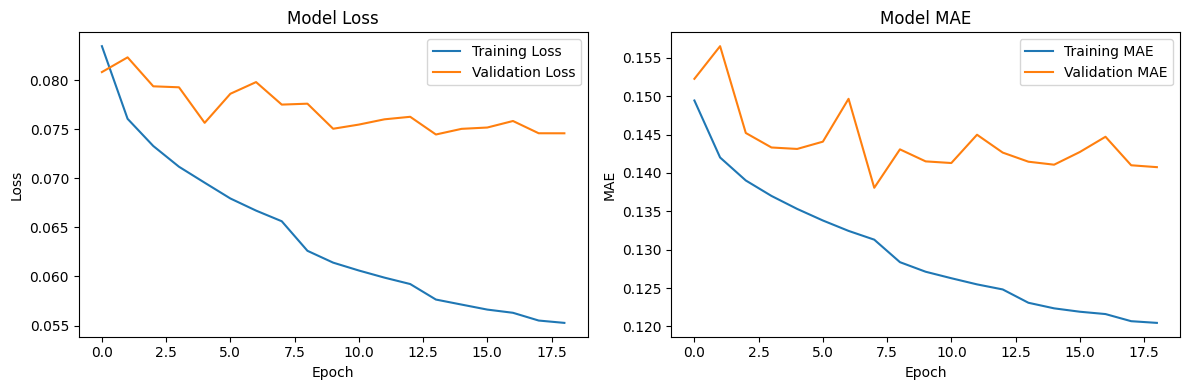

In [11]:
# Plot training history
predictor.plot_history(history)

In [12]:
# Evaluate model
metrics, predictions, actual = predictor.evaluate(X_test, y_test)
print("Model Metrics:")
for metric, value in metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

7353/7353 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Model Metrics:
MSE: 0.9964
RMSE: 0.9982
MAE: 0.2995
R2: 0.0735


<ipython-input-4-0867e8f53bf2>:137: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


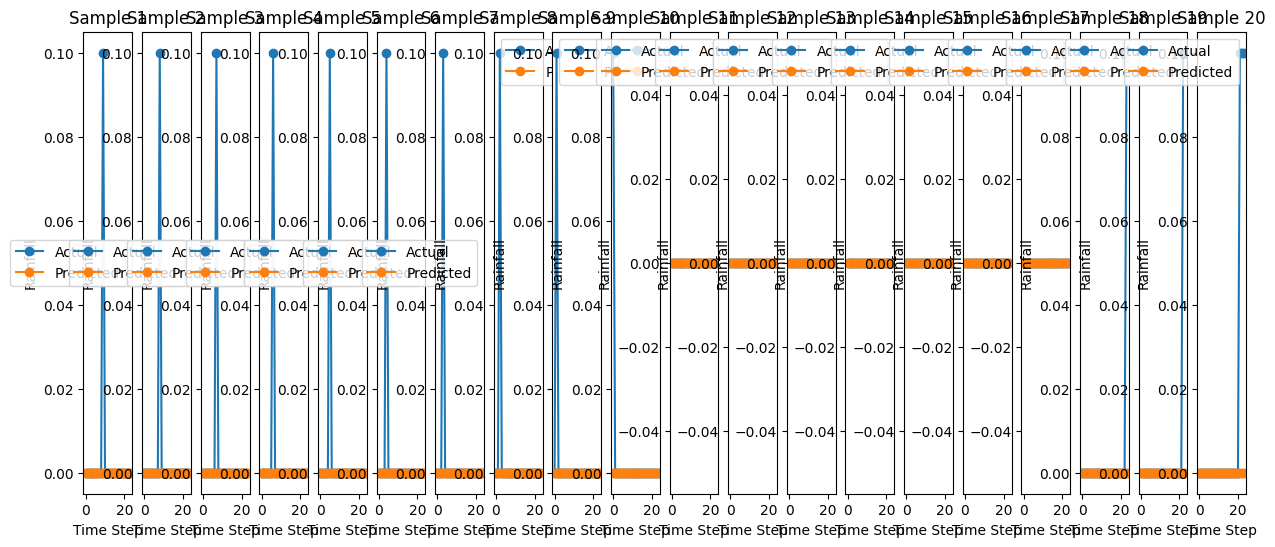

In [13]:
# Plot sample predictions
predictor.plot_predictions(predictions, actual, num_samples=20)